# Intersection Characteristics Analysis of master_gdf
This file takes you through the data cleaning, analysis, and visualization of the intersection characteristics in the master_gdf. By analyzing the relationships between the intersection characteristics and motor collisions, features will be engineered to train the machine learning model to better predict the safety of each intersection.  


# 1: Downloading the Data

In [1]:
# Import libraries
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import requests
import geopandas as gpd
import folium
from folium import Marker
from geopy.distance import geodesic
from scipy.spatial import KDTree
from scipy.spatial import cKDTree
import warnings

# Ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Read the CSV file into a DataFrame
master_gdf = pd.read_csv('master_gdf.csv')

C:\Users\princ\AppData\Local\Temp\ipykernel_23384\2212490005.py:2: DtypeWarning: Columns (0,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  master_gdf = pd.read_csv('master_gdf.csv')


In [3]:
master_gdf.head()

,ACCNUM,YEAR,DATE,TIME,collision_datetime,STREET1,STREET2,OFFSET,ROAD_CLASS,DISTRICT,...,hourly_ex_peds,hourly_wx_peds,hourly_nx_bike,hourly_sx_bike,hourly_ex_bike,hourly_wx_bike,hourly_nx_other,hourly_sx_other,hourly_ex_other,hourly_wx_other
0,1237939,2011.0,2011-03-09,726,2011-03-09 07:26:00,COLLEGE Stre,BATHURST Stre,None,Major Arterial,Toronto and East York,...,208.0,160.0,50.0,2.0,43.0,312.0,0.0,0.0,0.0,0.0
1,1232522,2011.0,2011-03-09,1145,2011-03-09 11:45:00,JANE ST,ST JOHNS RD,None,Major Arterial,Toronto and East York,...,59.0,36.0,0.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0
2,1232522,2011.0,2011-03-09,1145,2011-03-09 11:45:00,JANE ST,ST JOHNS RD,None,Major Arterial,Toronto and East York,...,59.0,36.0,0.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0
3,1232522,2011.0,2011-03-09,1145,2011-03-09 11:45:00,JANE ST,ST JOHNS RD,None,Major Arterial,Toronto and East York,...,59.0,36.0,0.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0
4,1222866,2011.0,2011-03-12,1917,2011-03-12 19:17:00,CHURCH ST,GOULD ST,None,Minor Arterial,Toronto and East York,...,222.0,97.0,106.0,27.0,31.0,9.0,0.0,0.0,0.0,0.0


# 2: Visualizations and Analysis

## 2.1: Road Classification 

In [4]:
# Display unique values in the "ROAD_CLASS" column
road_class_values = master_gdf['ROAD_CLASS'].unique()
print("Unique values in ROAD_CLASS column:")
print(road_class_values)

Unique values in ROAD_CLASS column:
['Major Arterial' 'Minor Arterial' 'Local' 'None' 'Collector' 'Other'
 'Expressway' 'Expressway Ramp' 'Major Arterial Ramp' 'Laneway']


[The City of Toronto defines each of these road classes as such:](https://www.toronto.ca/services-payments/streets-parking-transportation/traffic-management/road-classification-system/about-the-road-classification-system/)

**Major Arterial:**
- Traffic movement is a primary function
- Subject to access controls
- Greater than 20,000 vehicles per day
- Greater than 5,000 bus passengers per day
- Speed limits 50 to 60 km/h
- Cyclists – special facilities desirable
- Sidewalks on both sides
- High priority of winter maintenance

**Minor Arterial:**
- Traffic movement is a primary function
- Some property access control
- 8,000 to 20,000 vehicles per day
- 1,500 to 5,000 bus passenger per day
- Speed limits 40 to 60 km/h
- No “Stop” signs; main intersections controlled by traffic signals
- No truck restrictions
- Sidewalks on both sides
- High priority of winter maintenance

**Local Road:**
- Provide access to property
- Less than 2,500 vehicles per day
- Low traffic speed
- Generally no bus routes
- Cyclists – special facilities as required
- Sidewalks on at least one side of road
- Truck restrictions preferred
- Low priority for winter maintenance

**Collector Road:**
- Provide access to property and traffic movement
- 2,500 to 8,000 vehicles per day
- Less than 1,500 bus (or streetcar) passenger per day
- Signalized intersections at arterial roads
- Truck restrictions permitted
- Cyclists – special facilities as required
- Sidewalks on both sides of the road
- Medium priority for winter maintenance

**Expressway Road:**
- Traffic movement is a primary function
- No property access
- Speed limits 80 to 100 km/h
- Greater than 40,000 vehicles per day
- No local transit service
- Pedestrians and cyclists prohibited
- Grade-separated intersections (no traffic signals)
- Highest priority of winter maintenance

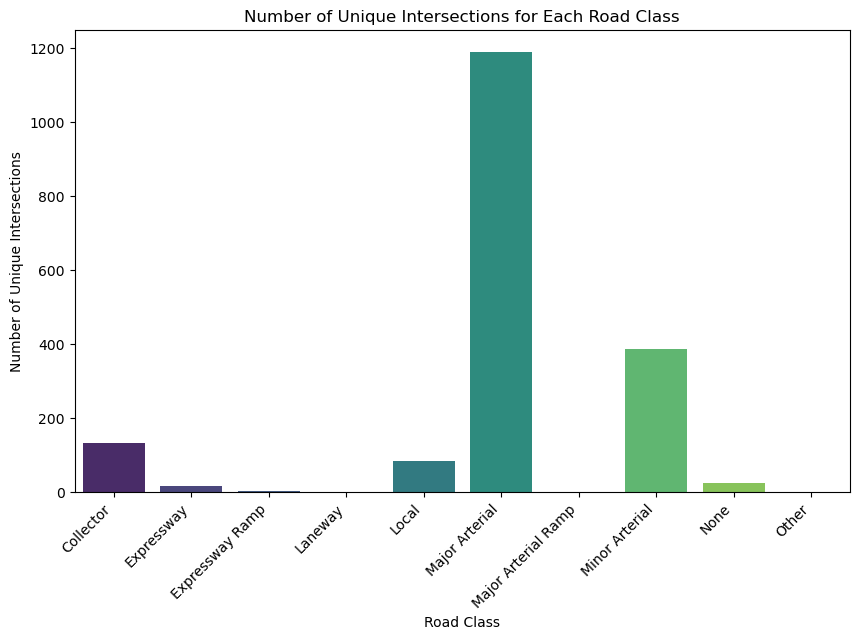

In [5]:
intersection_counts_by_road_class = master_gdf.groupby('ROAD_CLASS')['count_location'].nunique().reset_index(name='Number_of_Unique_Intersections')

# Plotting the data
plt.figure(figsize=(10, 6))
sns.barplot(x='ROAD_CLASS', y='Number_of_Unique_Intersections', data=intersection_counts_by_road_class, palette='viridis')
plt.title('Number of Unique Intersections for Each Road Class')
plt.xlabel('Road Class')
plt.ylabel('Number of Unique Intersections')
plt.xticks(rotation=45, ha='right')
plt.show()

Most of the data in master_gdf is regarding major and minor arterials, and while Toronto does have indeed have expressways, the master_gdf does not carry that much data on them. The dataset is definitely scewed to arterial roads. 

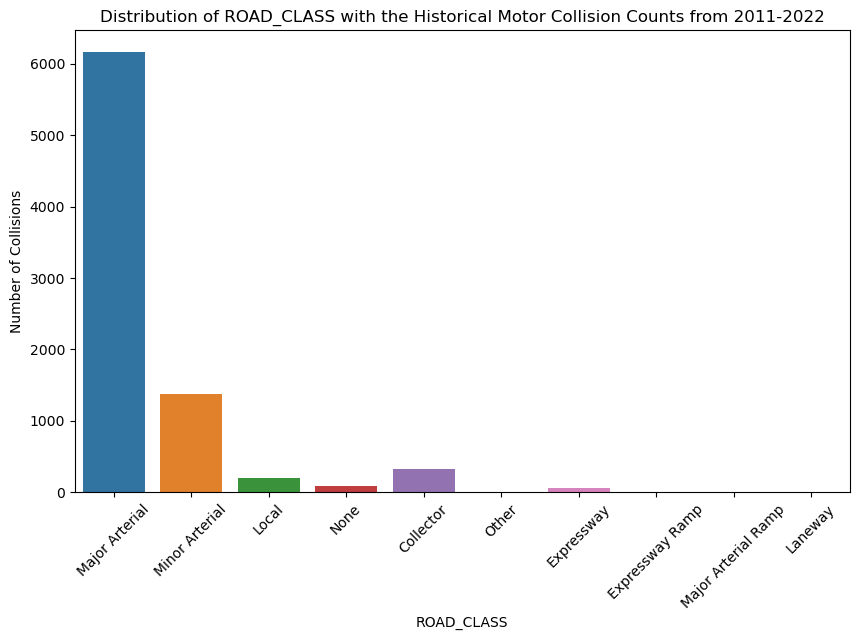

In [6]:
# Plot the distribution of ROAD_CLASS
plt.figure(figsize=(10, 6))
sns.countplot(x='ROAD_CLASS', data=master_gdf)
plt.title('Distribution of ROAD_CLASS with the Historical Motor Collision Counts from 2011-2022')
plt.xlabel('ROAD_CLASS')
plt.ylabel('Number of Collisions')
plt.xticks(rotation=45)
plt.show()

In [7]:
# Numerical breakdown for ROAD_CLASS
road_class_breakdown = master_gdf.groupby('ROAD_CLASS').size().reset_index(name='Number_of_Collisions_RoadClass')
print('Numerical breakdown for ROAD_CLASS:')
print(road_class_breakdown)

Numerical breakdown for ROAD_CLASS:
            ROAD_CLASS  Number_of_Collisions_RoadClass
0            Collector                             330
1           Expressway                              62
2      Expressway Ramp                               4
3              Laneway                               1
4                Local                             198
5       Major Arterial                            6162
6  Major Arterial Ramp                               1
7       Minor Arterial                            1375
8                 None                              82
9                Other                               2


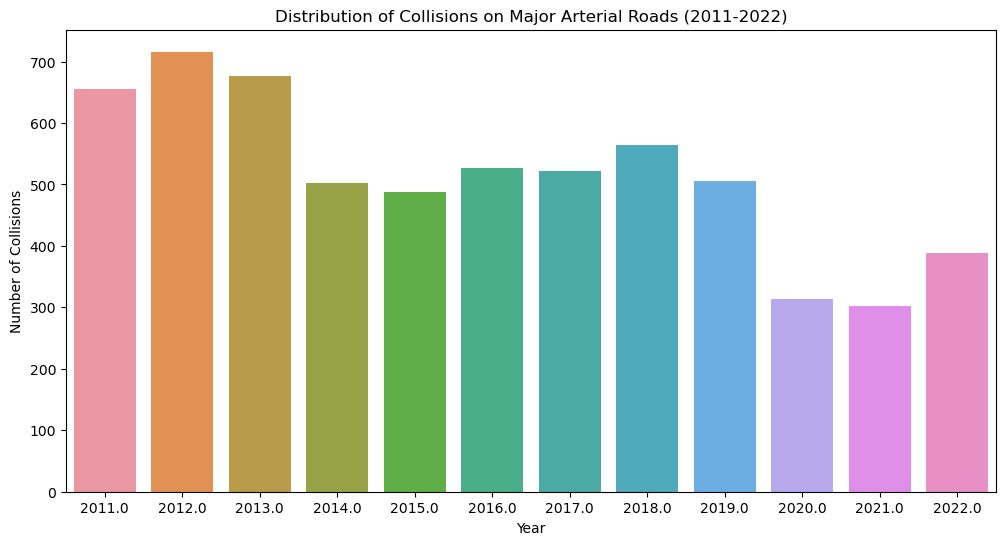

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the data for Major Arterial roads
major_arterial_data = master_gdf[master_gdf['ROAD_CLASS'] == ('Major Arterial' or 'Minor Arterial')]

# Plot the distribution of collisions for Major Arterial roads for every year
plt.figure(figsize=(12, 6))
sns.countplot(x='YEAR', data=major_arterial_data)
plt.title('Distribution of Collisions on Major Arterial Roads (2011-2022)')
plt.xlabel('Year')
plt.ylabel('Number of Collisions')
plt.show()

In [9]:
# If your timestamp is in a different format, adjust the code accordingly
master_gdf['YEAR'] = pd.to_datetime(master_gdf['DATE']).dt.year

# Filter the data for Major Arterial roads
major_arterial_data = master_gdf[master_gdf['ROAD_CLASS'] == 'Major Arterial']

# Calculate the numerical breakdown for Major Arterial roads per year
major_arterial_breakdown = major_arterial_data.groupby('YEAR').size().reset_index(name='Number_of_Collisions_MajorArterial')
print('Numerical breakdown for Collisions on Major Arterial Roads per Year:')
print(major_arterial_breakdown)

Numerical breakdown for Collisions on Major Arterial Roads per Year:
    YEAR  Number_of_Collisions_MajorArterial
0   2011                                 655
1   2012                                 716
2   2013                                 677
3   2014                                 502
4   2015                                 488
5   2016                                 527
6   2017                                 522
7   2018                                 564
8   2019                                 506
9   2020                                 314
10  2021                                 303
11  2022                                 388


After 2013 we see a sharp drop in collisions on major and minor arterials and this marks the beginning stages of the implementation of [Vision Zero](https://www.toronto.ca/services-payments/streets-parking-transportation/road-safety/vision-zero/vision-zero-dashboard/red-light-camera-vision-zero/) in Toronto. Vision Zero is an initiative that focuses on reducing traffic-related fatalities and serious injuries on Toronto’s streets.Increasing traffic safety and calming measures on arterials have been implemented since this time such as the installation of red light cameras, traffic signals, and pedestrian crossovers are just some of the measures taken in Toronto's Vision Zero Road Safety Action Plan. Let's investigate the impact on these traffic controls on intersections further.

Intersections with High Average Collision Rates:
                                         count_location  Avg_Num_Collisions
1     # 3030 BIRCHMOUNT RD AT BIRCHMOUNT RD (NORTH D...                3.00
2     # 4400 DUFFERIN ST AT DUFFERIN ST & 250M N STA...                3.00
4                                      3410 MIDLAND AVE                4.00
7                         ADELAIDE ST AT BAY ST (PX 62)                3.50
8                  ADELAIDE ST AT BERKELEY ST (PX 1964)                4.00
...                                                 ...                 ...
1689  YONGE ST AT 280M S OF CUMMER AVE & # 5791 - 58...                5.00
1690                YONGE ST AT CARLTON ST & COLLEGE ST                4.00
1691                             YONGE ST AT CENTRE AVE                3.00
1696  YONGE ST AT ORCHARD VIEW BLVD & ROEHAMPTON AVE...                3.00
1698             YONGE ST AT WILSON AVE & YORK MILLS RD                4.75

[703 rows x 2 columns]


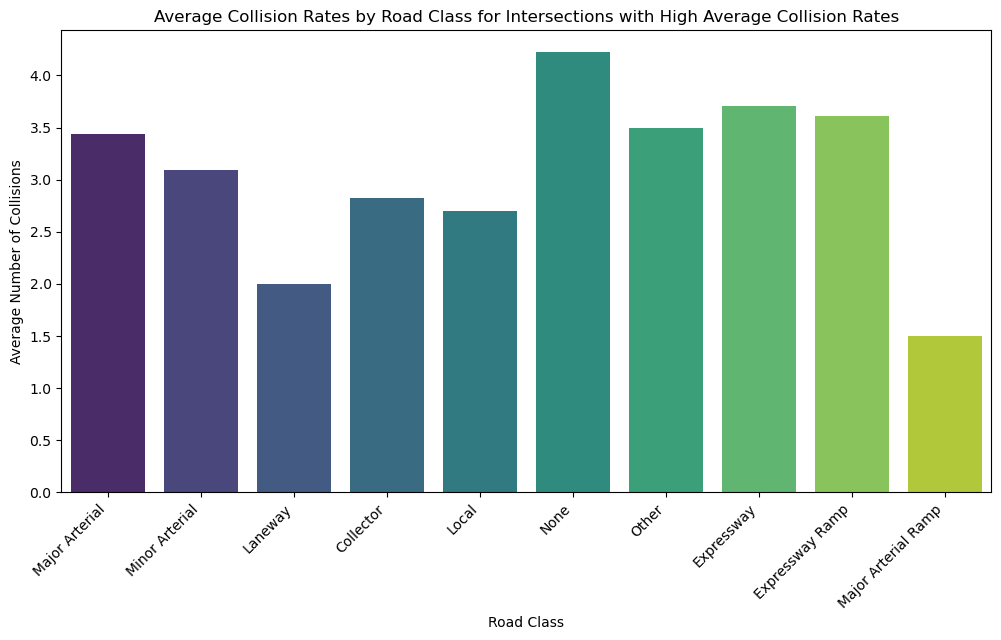

In [10]:
# Calculate the average number of collisions per year for each intersection
avg_collisions_per_intersection = master_gdf.groupby(['count_location', 'YEAR']).size().reset_index(name='Num_Collisions')
avg_collisions_per_intersection = avg_collisions_per_intersection.groupby('count_location')['Num_Collisions'].mean().reset_index(name='Avg_Num_Collisions')

# Identify intersections with high average collision rates (adjust the threshold as needed)
high_collision_intersections = avg_collisions_per_intersection[avg_collisions_per_intersection['Avg_Num_Collisions'] > avg_collisions_per_intersection['Avg_Num_Collisions'].mean()]

# Print or visualize the intersections with high average collision rates
print('Intersections with High Average Collision Rates:')
print(high_collision_intersections)

# You can also create visualizations to explore common characteristics
# For example, a bar plot of average collision rates for each road class
plt.figure(figsize=(12, 6))
sns.barplot(x='ROAD_CLASS', y='Avg_Num_Collisions', data=master_gdf.merge(avg_collisions_per_intersection, on='count_location'), ci=None, palette='viridis')
plt.title('Average Collision Rates by Road Class for Intersections with High Average Collision Rates')
plt.xlabel('Road Class')
plt.ylabel('Average Number of Collisions')
plt.xticks(rotation=45, ha='right')
plt.show()

In [11]:
# Unique values for ACCLASS
unique_acclass = master_gdf['ACCLASS'].unique()
print("Unique values in ACCLASS column:")
print(unique_acclass)

# Unique values for VEHTYPE
unique_vehtype = master_gdf['VEHTYPE'].unique()
print("\nUnique values in VEHTYPE column:")
print(unique_vehtype)

Unique values in ACCLASS column:
['Non-Fatal Injury' 'Fatal' 'Property Damage Only' 'None']

Unique values in VEHTYPE column:
['Other' 'Automobile, Station Wagon' 'Truck - Open' 'Bicycle' 'Motorcycle'
 'Municipal Transit Bus (TTC)' 'Taxi' 'None' 'Moped' 'Pick Up Truck'
 'Passenger Van' 'Truck - Closed (Blazer, etc)' 'Street Car'
 'Truck-Tractor' 'Delivery Van' 'Truck - Dump'
 'Bus (Other) (Go Bus, Gray Coach)' 'Intercity Bus'
 'Construction Equipment' 'Truck (other)' 'Truck - Tank' 'Tow Truck'
 'Police Vehicle' 'Fire Vehicle' 'Other Emergency Vehicle' 'School Bus'
 'Truck - Car Carrier' 'Ambulance' 'Railway Train' 'Off Road - Other']


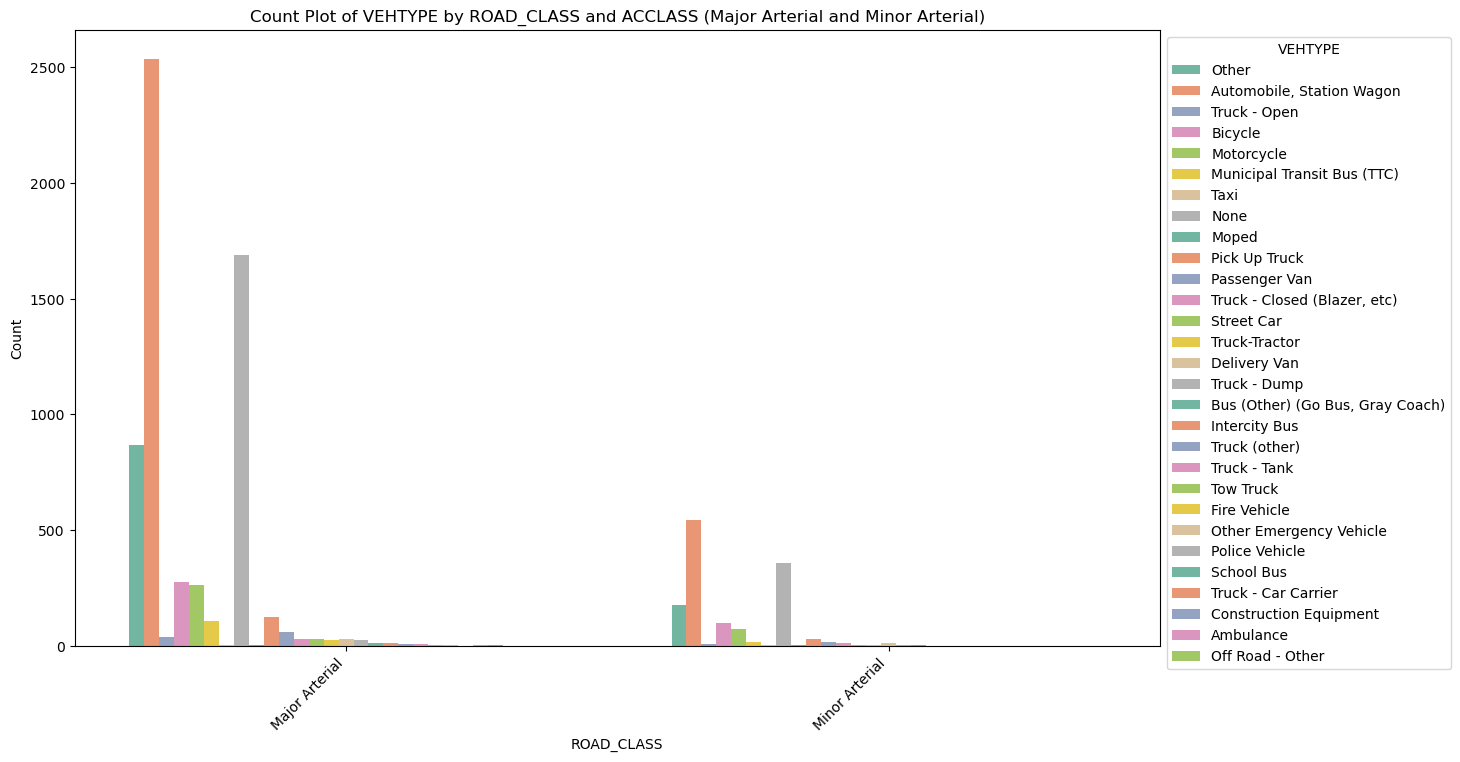

In [12]:
# Define a custom color palette
custom_palette = sns.color_palette("Set2")

# Filter data for Major Arterial and Minor Arterial
filtered_data = master_gdf[master_gdf['ROAD_CLASS'].isin(['Major Arterial', 'Minor Arterial'])]

# Count plot for VEHTYPE by ROAD_CLASS and ACCLASS
plt.figure(figsize=(14, 8))
sns.countplot(x='ROAD_CLASS', hue='VEHTYPE', data=filtered_data, palette=custom_palette)
plt.title('Count Plot of VEHTYPE by ROAD_CLASS and ACCLASS (Major Arterial and Minor Arterial)')
plt.xlabel('ROAD_CLASS')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='VEHTYPE', bbox_to_anchor=(1, 1))
plt.show()

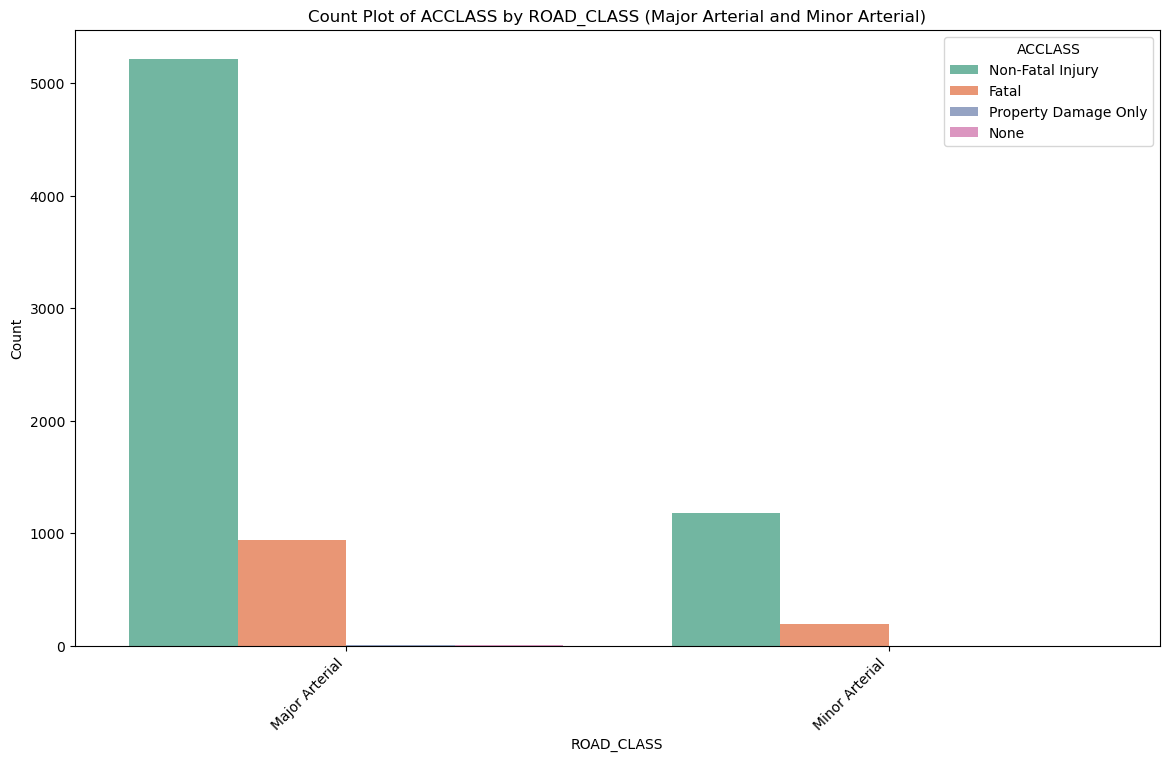

In [13]:
# Define a custom color palette
custom_palette = sns.color_palette("Set2")

# Filter data for Major Arterial and Minor Arterial
filtered_data = master_gdf[master_gdf['ROAD_CLASS'].isin(['Major Arterial', 'Minor Arterial'])]

# Count plot for ACCLASS by ROAD_CLASS
plt.figure(figsize=(14, 8))
sns.countplot(x='ROAD_CLASS', hue='ACCLASS', data=filtered_data, palette=custom_palette)
plt.title('Count Plot of ACCLASS by ROAD_CLASS (Major Arterial and Minor Arterial)')
plt.xlabel('ROAD_CLASS')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='ACCLASS', bbox_to_anchor=(1, 1))
plt.show()

## 2.2: Traffic Control

In [14]:
# Display unique values in the "TRAFFCTL" column
traffctl_values = master_gdf['TRAFFCTL'].unique()
print("\nUnique values in TRAFFCTL column:")
print(traffctl_values)


Unique values in TRAFFCTL column:
['No Control' 'Traffic Signal' 'Stop Sign' 'Pedestrian Crossover'
 'Streetcar (Stop for)' 'Traffic Controller' 'None' 'Yield Sign']


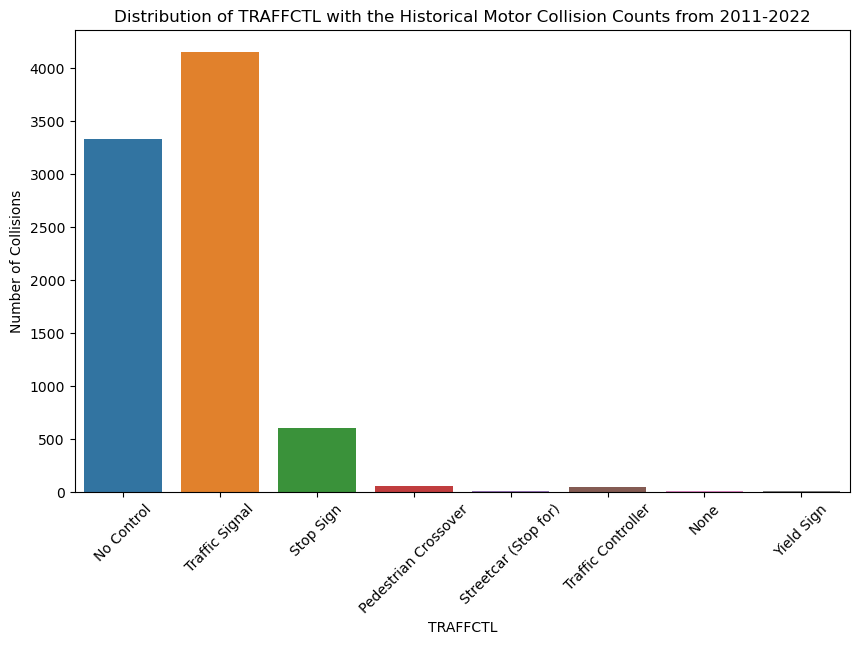

In [15]:
# Plot the distribution of TRAFFCTL
plt.figure(figsize=(10, 6))
sns.countplot(x='TRAFFCTL', data=master_gdf)
plt.title('Distribution of TRAFFCTL with the Historical Motor Collision Counts from 2011-2022')
plt.xlabel('TRAFFCTL')
plt.ylabel('Number of Collisions')
plt.xticks(rotation=45)
plt.show()

In [16]:
# Numerical breakdown for TRAFFCTL
traffctl_breakdown = master_gdf.groupby('TRAFFCTL').size().reset_index(name='Number_of_Collisions_TraffCtl')
print('\nNumerical breakdown for TRAFFCTL:')
print(traffctl_breakdown)


Numerical breakdown for TRAFFCTL:
               TRAFFCTL  Number_of_Collisions_TraffCtl
0            No Control                           3329
1                  None                              8
2  Pedestrian Crossover                             58
3             Stop Sign                            607
4  Streetcar (Stop for)                              9
5    Traffic Controller                             49
6        Traffic Signal                           4152
7            Yield Sign                              5


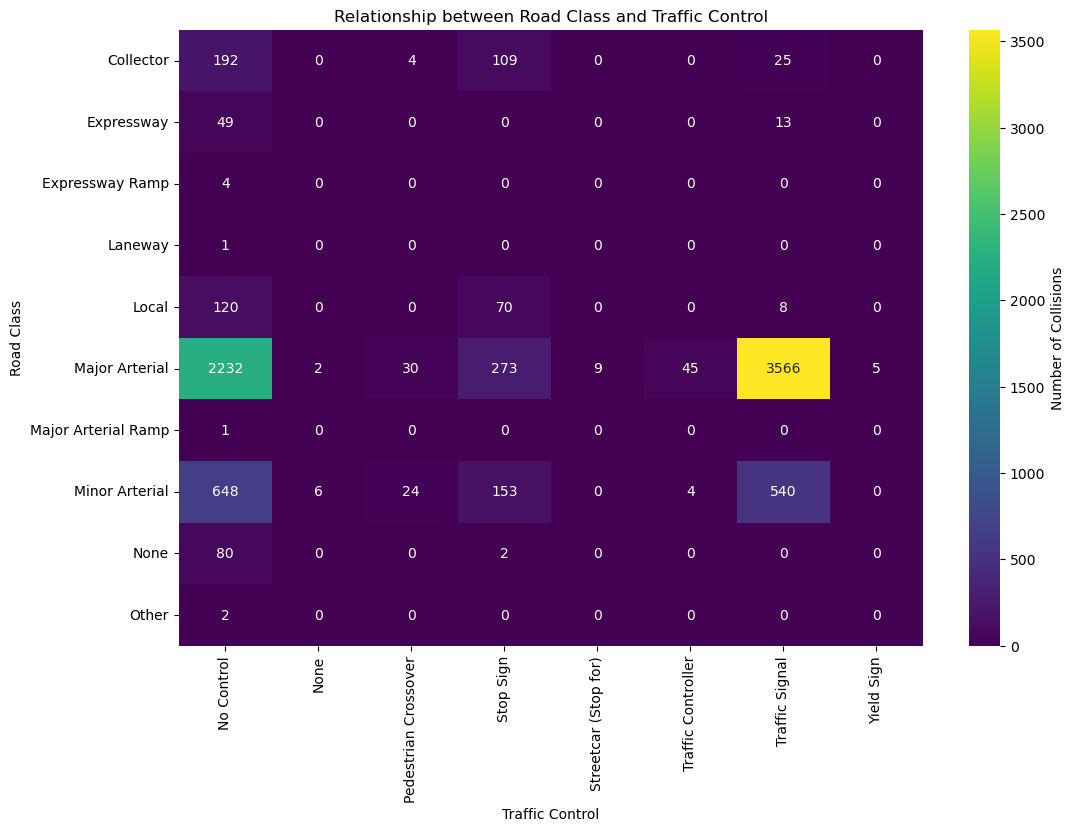

In [17]:
# Create a pivot table to count collisions for each combination of ROAD_CLASS and TRAFFCTL
pivot_table = master_gdf.pivot_table(index='ROAD_CLASS', columns='TRAFFCTL', aggfunc='size', fill_value=0)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt='d', cmap='viridis', cbar_kws={'label': 'Number of Collisions'})
plt.title('Relationship between Road Class and Traffic Control')
plt.xlabel('Traffic Control')
plt.ylabel('Road Class')
plt.show()

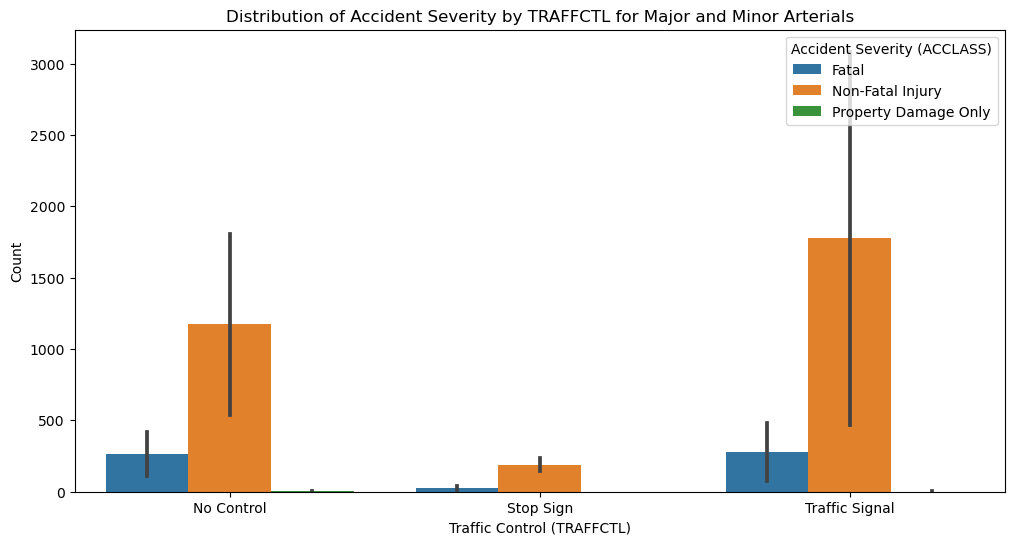

In [18]:
# Filter data for Major Arterial and Minor Arterial
filtered_data = master_gdf[master_gdf['ROAD_CLASS'].isin(['Major Arterial', 'Minor Arterial'])]

# Filter data for specific TRAFFCTL categories
selected_traffctl = ['No Control', 'Stop Sign', 'Traffic Signal']
filtered_data = filtered_data[filtered_data['TRAFFCTL'].isin(selected_traffctl)]

# Filter out 'None' from ACCLASS
filtered_data = filtered_data[filtered_data['ACCLASS'] != 'None']

# Create a DataFrame with counts for each combination of ROAD_CLASS, TRAFFCTL, and ACCLASS
severity_counts = filtered_data.groupby(['ROAD_CLASS', 'TRAFFCTL', 'ACCLASS']).size().reset_index(name='Count')

# Pivot the DataFrame to have ACCLASS as columns
severity_pivot = severity_counts.pivot_table(index=['ROAD_CLASS', 'TRAFFCTL'], columns='ACCLASS', values='Count', fill_value=0).reset_index()

# Melt the DataFrame to make it suitable for seaborn barplot
severity_melted = pd.melt(severity_pivot, id_vars=['ROAD_CLASS', 'TRAFFCTL'], var_name='ACCLASS', value_name='Count')

# Plot stacked bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='TRAFFCTL', y='Count', hue='ACCLASS', data=severity_melted)
plt.title('Distribution of Accident Severity by TRAFFCTL for Major and Minor Arterials')
plt.xlabel('Traffic Control (TRAFFCTL)')
plt.ylabel('Count')
plt.legend(title='Accident Severity (ACCLASS)', loc='upper right')
plt.show()

In [19]:
# Filter data for Major Arterial and Minor Arterial
filtered_data = master_gdf[master_gdf['ROAD_CLASS'].isin(['Major Arterial', 'Minor Arterial'])]

# Filter data for specific TRAFFCTL categories
selected_traffctl = ['No Control', 'Stop Sign', 'Traffic Signal']
filtered_data = filtered_data[filtered_data['TRAFFCTL'].isin(selected_traffctl)]

# Filter out 'None' from ACCLASS
filtered_data = filtered_data[filtered_data['ACCLASS'] != 'None']

# Create a DataFrame with counts for each combination of TRAFFCTL and ACCLASS
severity_counts = filtered_data.groupby(['TRAFFCTL', 'ACCLASS']).size().reset_index(name='Count')

# Pivot the DataFrame to have ACCLASS as columns
severity_pivot = severity_counts.pivot_table(index='TRAFFCTL', columns='ACCLASS', values='Count', fill_value=0).reset_index()

# Calculate fatality ratio (Fatal to Non-Fatal Injury)
severity_pivot['Fatality_Ratio'] = severity_pivot['Fatal'] / severity_pivot['Non-Fatal Injury']

# Display the resulting DataFrame
print(severity_pivot[['TRAFFCTL', 'Fatal', 'Non-Fatal Injury', 'Fatality_Ratio']])

ACCLASS        TRAFFCTL  Fatal  Non-Fatal Injury  Fatality_Ratio
0            No Control    526              2347        0.224116
1             Stop Sign     47               379        0.124011
2        Traffic Signal    552              3550        0.155493


# 3: Feature Engineering

In [32]:
# Read the CSV file into a DataFrame
master_att_gdf = pd.read_csv('master_att_gdf.csv')
master_att_gdf

,ACCNUM,YEAR,DATE,TIME,collision_datetime,STREET1,STREET2,OFFSET,ROAD_CLASS,DISTRICT,...,ELEVATION,ELEVATION_UNIT,HEIGHT_RESTRICTION,HEIGHT_RESTRICTION_UNIT,STATE,TRANS_ID_CREATE,TRANS_ID_EXPIRE,OBJECTID,type,coordinates
0,1233009,2011.0,2011-03-15,852,2011-03-15 08:52:00,KING Stre E,PRINCESS Stre,None,Major Arterial,Toronto and East York,...,0.0,NaN,0.0,NaN,8,200000,-1,29443,MultiPoint,"[[-79.3670506171421, 43.6515475861724]]"
1,1233009,2011.0,2011-03-15,852,2011-03-15 08:52:00,KING Stre E,PRINCESS Stre,None,Major Arterial,Toronto and East York,...,0.0,NaN,0.0,NaN,8,200000,-1,29443,MultiPoint,"[[-79.3670506171421, 43.6515475861724]]"
2,1233009,2011.0,2011-03-15,852,2011-03-15 08:52:00,KING Stre E,PRINCESS Stre,None,Major Arterial,Toronto and East York,...,0.0,NaN,0.0,NaN,8,200000,-1,29443,MultiPoint,"[[-79.3670506171421, 43.6515475861724]]"
3,1233009,2011.0,2011-03-15,852,2011-03-15 08:52:00,KING Stre E,PRINCESS Stre,None,Major Arterial,Toronto and East York,...,0.0,NaN,0.0,NaN,8,200000,-1,29443,MultiPoint,"[[-79.3670506171421, 43.6515475861724]]"
4,1233009,2011.0,2011-03-15,852,2011-03-15 08:52:00,KING Stre E,PRINCESS Stre,None,Major Arterial,Toronto and East York,...,0.0,NaN,0.0,NaN,8,200000,-1,29443,MultiPoint,"[[-79.3670506171421, 43.6515475861724]]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2294,2002494669,2022.0,2022-12-21,1750,2022-12-21 17:50:00,GLOUCESTER GRV,WINNETT AVE,None,Local,None,...,0.0,NaN,0.0,NaN,8,200000,-1,5405,MultiPoint,"[[-79.4359754197162, 43.6955080379418]]"
2295,2002494669,2022.0,2022-12-21,1750,2022-12-21 17:50:00,GLOUCESTER GRV,WINNETT AVE,None,Local,None,...,0.0,NaN,0.0,NaN,8,200000,-1,5405,MultiPoint,"[[-79.4359754197162, 43.6955080379418]]"
2296,2002494669,2022.0,2022-12-21,1750,2022-12-21 17:50:00,GLOUCESTER GRV,WINNETT AVE,None,Local,None,...,0.0,NaN,0.0,NaN,8,200000,-1,5405,MultiPoint,"[[-79.4359754197162, 43.6955080379418]]"
2297,2002494669,2022.0,2022-12-21,1750,2022-12-21 17:50:00,GLOUCESTER GRV,WINNETT AVE,None,Local,None,...,0.0,NaN,0.0,NaN,8,200000,-1,5405,MultiPoint,"[[-79.4359754197162, 43.6955080379418]]"


In [41]:
# Read the CSV file into a DataFrame
master_intersection_gdf = pd.read_csv('intersection_r.csv')
master_intersection_gdf

,count_location,ROAD_CLASS,TRAFFCTL,num_of_collisions,total_traffic,average_int_width,years,r
0,BATHURST ST AT COLLEGE ST (PX 300),Major Arterial,No Control,18,20083.944444,0.015,11,1.488150
1,JANE ST AT ST JOHNS RD (PX 523),Major Arterial,Traffic Signal,3,11620.000000,0.015,11,0.428685
2,CHURCH ST AT GOULD ST (PX 993),Minor Arterial,Traffic Signal,10,9440.000000,0.015,11,1.758941
3,CHARLES ST E AT CHURCH ST (PX 225),Minor Arterial,No Control,2,11585.000000,0.015,11,0.286653
4,KING ST E AT PRINCESS ST,Major Arterial,No Control,11,5304.000000,0.015,11,3.443597
...,...,...,...,...,...,...,...,...
1696,KINGSTON RD AT MARKHAM RD,Major Arterial,Traffic Signal,2,20556.000000,0.015,11,0.161553
1697,ALBION RD AT BENSTROW AVE & SANAGAN RD (PX 1953),Major Arterial,No Control,2,14765.000000,0.015,11,0.224916
1698,AVENUE RD AT LONSDALE RD (PX 113),Major Arterial,Traffic Signal,2,19238.000000,0.015,11,0.172621
1699,AVA RD AT WINNETT AVE,Local,Stop Sign,5,2427.000000,0.015,11,3.420766


### Including Elevations Columns to master_intersection_gdf 

In [42]:
# Merge the dataframes based on 'count_location'
merged_df = pd.merge(master_intersection_gdf, master_att_gdf[['count_location', 'NUMBER_OF_ELEVATIONS']], on='count_location', how='left')

# Find the first instance of each intersection
first_instance_df = merged_df.groupby('count_location')['NUMBER_OF_ELEVATIONS'].first().reset_index()

# Rename the columns for clarity
first_instance_df.columns = ['count_location', 'number_of_elevations']

# Merge the new column back into master_intersection_gdf
master_intersection_gdf = pd.merge(master_intersection_gdf, first_instance_df, on='count_location', how='left')

# Fill NaN values with a default value if needed
master_intersection_gdf['number_of_elevations'].fillna(0, inplace=True)

In [50]:
master_intersection_gdf['number_of_elevations']

0       0.0
1       0.0
2       0.0
3       0.0
4       1.0
       ... 
1696    1.0
1697    0.0
1698    0.0
1699    1.0
1700    0.0
Name: number_of_elevations, Length: 1701, dtype: float64

## 3.1 Identifying Road Classes High Historical Collisions

In [25]:
def add_major_arterial_column(df):
    # Create a new column 'major_arterial' with values 1 for 'Major Arterial', 0 otherwise
    df['major_arterial'] = (df['ROAD_CLASS'] == 'Major Arterial').astype(int)
    
    return df

In [27]:
#Checking if this works
master_intersection_gdf = add_major_arterial_column(master_intersection_gdf)
master_intersection_gdf

,count_location,ROAD_CLASS,TRAFFCTL,num_of_collisions,total_traffic,average_int_width,years,r,num_non-fatal_injury,num_fatal,num_property_damage_only,num_none,major_arterial
0,BATHURST ST AT COLLEGE ST (PX 300),Major Arterial,No Control,18,20083.944444,0.015,11,1.488150,0,18,0,0,1
1,JANE ST AT ST JOHNS RD (PX 523),Major Arterial,Traffic Signal,3,11620.000000,0.015,11,0.428685,0,3,0,0,1
2,CHURCH ST AT GOULD ST (PX 993),Minor Arterial,Traffic Signal,10,9440.000000,0.015,11,1.758941,0,10,0,0,0
3,CHARLES ST E AT CHURCH ST (PX 225),Minor Arterial,No Control,2,11585.000000,0.015,11,0.286653,0,2,0,0,0
4,KING ST E AT PRINCESS ST,Major Arterial,No Control,11,5304.000000,0.015,11,3.443597,2,9,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1696,KINGSTON RD AT MARKHAM RD,Major Arterial,Traffic Signal,2,20556.000000,0.015,11,0.161553,0,2,0,0,1
1697,ALBION RD AT BENSTROW AVE & SANAGAN RD (PX 1953),Major Arterial,No Control,2,14765.000000,0.015,11,0.224916,0,0,0,2,1
1698,AVENUE RD AT LONSDALE RD (PX 113),Major Arterial,Traffic Signal,2,19238.000000,0.015,11,0.172621,0,2,0,0,1
1699,AVA RD AT WINNETT AVE,Local,Stop Sign,5,2427.000000,0.015,11,3.420766,0,5,0,0,0


## 3.2 Assigning Fatality Ratios to each Form of Traffic Control

In [28]:
def calculate_fatality_ratios(master_att_gdf):
    # Filter out rows with 'None' in ACCLASS
    filtered_data = master_att_gdf[master_att_gdf['ACCLASS'] != 'None']
    
    # Calculate fatality ratios for each TRAFFCTL category
    fatality_ratios_ctl = {}
    for traffctl_category in filtered_data['TRAFFCTL'].unique():
        subset = filtered_data[filtered_data['TRAFFCTL'] == traffctl_category]
        fatal_count = subset[subset['ACCLASS'] == 'Fatal'].shape[0]
        non_fatal_count = subset[subset['ACCLASS'] == 'Non-Fatal Injury'].shape[0]
        property_damage_count = subset[subset['ACCLASS'] == 'Property Damage Only'].shape[0]
        total_count = fatal_count + non_fatal_count + property_damage_count
        fatality_ratio = fatal_count / total_count if total_count > 0 else 0
        fatality_ratios_ctl[traffctl_category] = fatality_ratio
    
    return fatality_ratios_ctl

def add_fatality_ratio_ctl_column(df, fatality_ratios_ctl):
    # Create a new column 'fatality_ratio_ctl' based on 'TRAFFCTL'
    df['fatality_ratio_ctl'] = df['TRAFFCTL'].map(fatality_ratios_ctl)
    
    return df

In [30]:
#Checking if this works
# Calculate fatality ratios
fatality_ratios_ctl = calculate_fatality_ratios(master_att_gdf)

# Add 'fatality_ratio_ctl' column to master_intersection_gdf
master_intersection_gdf = add_fatality_ratio_ctl_column(master_intersection_gdf, fatality_ratios_ctl)
master_intersection_gdf

,count_location,ROAD_CLASS,TRAFFCTL,num_of_collisions,total_traffic,average_int_width,years,r,num_non-fatal_injury,num_fatal,num_property_damage_only,num_none,major_arterial,fatality_ratio_ctl
0,BATHURST ST AT COLLEGE ST (PX 300),Major Arterial,No Control,18,20083.944444,0.015,11,1.488150,0,18,0,0,1,0.173482
1,JANE ST AT ST JOHNS RD (PX 523),Major Arterial,Traffic Signal,3,11620.000000,0.015,11,0.428685,0,3,0,0,1,0.133976
2,CHURCH ST AT GOULD ST (PX 993),Minor Arterial,Traffic Signal,10,9440.000000,0.015,11,1.758941,0,10,0,0,0,0.133976
3,CHARLES ST E AT CHURCH ST (PX 225),Minor Arterial,No Control,2,11585.000000,0.015,11,0.286653,0,2,0,0,0,0.173482
4,KING ST E AT PRINCESS ST,Major Arterial,No Control,11,5304.000000,0.015,11,3.443597,2,9,0,0,1,0.173482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1696,KINGSTON RD AT MARKHAM RD,Major Arterial,Traffic Signal,2,20556.000000,0.015,11,0.161553,0,2,0,0,1,0.133976
1697,ALBION RD AT BENSTROW AVE & SANAGAN RD (PX 1953),Major Arterial,No Control,2,14765.000000,0.015,11,0.224916,0,0,0,2,1,0.173482
1698,AVENUE RD AT LONSDALE RD (PX 113),Major Arterial,Traffic Signal,2,19238.000000,0.015,11,0.172621,0,2,0,0,1,0.133976
1699,AVA RD AT WINNETT AVE,Local,Stop Sign,5,2427.000000,0.015,11,3.420766,0,5,0,0,0,0.126853


## 3.3 Identifying Intersection on Uneven Terrain

In [51]:
def add_uneven_terrain_column(df):
    # Create a new column 'uneven_terrain'
    df['uneven_terrain'] = df['number_of_elevations'].apply(lambda x: 1 if x > 1 else 0)
    return df

In [53]:
#Checking if this works
master_intersection_gdf = add_uneven_terrain_column(master_intersection_gdf)
master_intersection_gdf

,count_location,ROAD_CLASS,TRAFFCTL,num_of_collisions,total_traffic,average_int_width,years,r,number_of_elevations,uneven_terrain
0,BATHURST ST AT COLLEGE ST (PX 300),Major Arterial,No Control,18,20083.944444,0.015,11,1.488150,0.0,0
1,JANE ST AT ST JOHNS RD (PX 523),Major Arterial,Traffic Signal,3,11620.000000,0.015,11,0.428685,0.0,0
2,CHURCH ST AT GOULD ST (PX 993),Minor Arterial,Traffic Signal,10,9440.000000,0.015,11,1.758941,0.0,0
3,CHARLES ST E AT CHURCH ST (PX 225),Minor Arterial,No Control,2,11585.000000,0.015,11,0.286653,0.0,0
4,KING ST E AT PRINCESS ST,Major Arterial,No Control,11,5304.000000,0.015,11,3.443597,1.0,0
...,...,...,...,...,...,...,...,...,...,...
1696,KINGSTON RD AT MARKHAM RD,Major Arterial,Traffic Signal,2,20556.000000,0.015,11,0.161553,1.0,0
1697,ALBION RD AT BENSTROW AVE & SANAGAN RD (PX 1953),Major Arterial,No Control,2,14765.000000,0.015,11,0.224916,0.0,0
1698,AVENUE RD AT LONSDALE RD (PX 113),Major Arterial,Traffic Signal,2,19238.000000,0.015,11,0.172621,0.0,0
1699,AVA RD AT WINNETT AVE,Local,Stop Sign,5,2427.000000,0.015,11,3.420766,1.0,0
